## Estimating model performance on the delia data which was used for COI analysis.

The 01_Resultaat... excel file can be found on the project's sharepoint.  
The pskw1 data are retrieved from the AWS S3 bucket (using the insects-api function backup_s3_folder(user='pskw1', s3_folder='pskw1', local_dir='/whatever')).  
The model is the one trained on all action lab data, and is stored in the exports folder (which is made using this repo's settings.py).  

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Let's add the parent directory to the path so we can import the module
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from utils import *
# !pip install openpyxl

#### Defining a helper function to save all extracted tiles in a folder

In [3]:
def process_group(group, path_export_tiles, tiles_labelled=None):
    """
    This function processes a group of rows from the delia data, and exports the tiles to a folder.
    
    Args:
    - group: pd.DataFrame
        A group of rows from the delia data.
    - path_export_tiles: str
        The path to the folder where the tiles should be exported.
    - tiles_labelled: list
        A list of strings, where each string is the plate_code and insect_idx of a tile that should be exported.
    """
    Path(path_export_tiles).mkdir(parents=True, exist_ok=True)
    assert 'filepath' in group.columns, "No filepath found in dataframe columns."

    path_img = group.filepath.value_counts().index[0].as_posix()
    assert Path(path_img).is_file(), f"File not found: {path_img}"
    assert isinstance(path_export_tiles, str), f"path_export_tiles should be a string, but is {type(path_export_tiles)}."
    assert isinstance(path_img, str), f"path_img should be a string, but is {type(path_img)}."
    plate_img = cv2.imread(path_img)

    if plate_img is None:
        print(f"Error: Could not load image: {path_img}")
        return

    H, W, _ = plate_img.shape

    for _, row in group.iterrows():
        if f"{row.plate_code}-{row.insect_idx}" not in tiles_labelled:
            # We're only interested in the tiles that are in the tiles_labelled list
            continue
        left = int((row.yolo_x-row.yolo_width/2.)*W)
        right = int((row.yolo_x+row.yolo_width/2.)*W)
        top = int((row.yolo_y-row.yolo_height/2.)*H)
        bot = int((row.yolo_y+row.yolo_height/2.)*H)

        if left < 0:
            left = 0
        if right > W-1:
            right = W-1
        if top < 0:
            top = 0
        if bot > H-1:
            bot = H-1

        tile = plate_img[top:bot, left:right]

        savepath = f"{path_export_tiles}/"
        Path(savepath).mkdir(parents=True, exist_ok=True)

        tile_path = os.path.join(savepath, f"{row.plate_code}-{row.insect_idx}.png")
        if not os.path.isfile(tile_path): cv2.imwrite(tile_path, tile)

### Read the COI analysis results, the data downloaded from the AWS S3 bucket and export the tiles

In [4]:
# Reading the excel file with the original data
df_og = pd.read_excel("01_Resultaat reeks1_2_3_WD.xlsx", sheet_name="Stalen_20240209", engine='openpyxl')
# Keeping only the relevant columns
df_og = df_og[['Jaar','Perceel','Staalnamemoment','Plaatnummer','Vliegnummer','Staalcode','commentaar finaal','species','% Identity in blastn search']]
# Let's drop the rows with NaN species
df_og = df_og.dropna(subset=['species'])
# Let's drop the rows with 

# List of csv files and images from the S3 bucket
s3_data_labels = list(Path('/home/kalfasyan/data/pskw1_dl').rglob('*.csv'))
s3_data_images = list(Path('/home/kalfasyan/data/pskw1_dl').rglob('*_rsz.png'))
# Sorting the lists to match the same order of images and labels
s3_data_images.sort()
s3_data_labels.sort()
# Creating a dataframe with all the information gathered from the csv files
all_df_labels = []
for i, (labelfile, imgfile) in enumerate(zip(s3_data_labels, s3_data_images)):
    df = pd.read_csv(labelfile)
    assert imgfile.stem.split('_')[0] == labelfile.stem.split('_')[1], f"{imgfile.stem} != {labelfile.stem}"
    df['plate_code'] = imgfile.stem.split('_')[0] # This is the plate code e.g. 23B11
    df['filepath'] = imgfile # This is the path to the image that contains the insect
    df['insect_idx'] = df.index # This is the index of the insect in the plate
    all_df_labels.append(df)
df_labels = pd.concat(all_df_labels)
df_labels.reset_index(drop=True, inplace=True) 

# Clear this directory '/home/kalfasyan/data/pskw1_dl/tiles'
for file in Path('/home/kalfasyan/data/pskw1_dl/tiles').rglob('*'):
    Path(file).unlink()

# Saving the insect image tiles to the directory '/home/kalfasyan/data/pskw1_dl/tiles'
for i, sub in df_labels.groupby('plate_code'):
    process_group(sub, '/home/kalfasyan/data/pskw1_dl/tiles', tiles_labelled=set(df_og.Staalcode.tolist()))

### Loading the model (v.Feb2024) and feeding all the data to it

In [5]:
# Loading the model
import torch
import timm

# Fetching the architecture from the timm library
timm_modelname = "mobilenetv3_large_100.miil_in21k_ft_in1k"
# Loading the weights from the trained model
my_modelname = "mobilenetv3_large_100.miil_in21k_ft_in1k_multi4_PTmulti12_best.pth.tar"
modelpath = Path("/home/kalfasyan/data/INSECTS/All_sticky_plate_images/created_data/exports/") / my_modelname
model = timm.create_model(timm_modelname, num_classes=12)
model.load_state_dict(torch.load(modelpath, map_location=torch.device('cpu'))['state_dict'])
# Moving to CPU for inference
model = model.to('cpu')
# Eval mode to disable layers like dropout/batchnorm
model.eval();

In [6]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Let's define the transformations
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
])

class InsectTilesCOI(Dataset):
    def __init__(self, img_directory, transform=None):
        self.img_directory = img_directory
        self.transform = transform
        self.img_paths = [x for x in Path(img_directory).rglob('*.png')]
        self.img_paths = sorted(self.img_paths)
        self.img_labels = [x.stem.split('_')[0] for x in self.img_paths]
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx].as_posix())
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, self.img_labels[idx]

ds = InsectTilesCOI('/home/kalfasyan/data/pskw1_dl/tiles', transform=transform)
dl = DataLoader(ds, batch_size=1, shuffle=False, num_workers=4)

# Let's iterate over the dataloader and make predictions
all_preds = []
all_labels = []
for img, label in tqdm(dl, total=len(ds), desc="Making predictions"):
    img = img.to('cpu')
    with torch.no_grad():
        pred = model(img)
    all_preds.append(pred)
    all_labels.append(label[0])

Making predictions:   0%|          | 0/732 [00:00<?, ?it/s]

### What does the model predict?

In [7]:
# The classification map used to train the model (v.Feb2024)
INSECT_CLASSIFICATION_MAP = {
    'bl': 0, 
    'sp': 1, 
    't': 2, 
    'sw': 3, 
    'k': 4, 
    'm': 5, 
    'c': 6, 
    'v': 7, 
    'kv': 8, 
    'wmv': 9, 
    'wrl': 10, 
    'not_insect': 11
    }
INV_INSECT_CLASSIFICATION_MAP = {v: k for k, v in INSECT_CLASSIFICATION_MAP.items()}

# Let's make a dataframe with the predictions and the labels
# We will only keep the argmax of the predictions (e.g. the class with the highest probability)
df_preds = pd.DataFrame(np.argmax(torch.cat(all_preds).numpy(), axis=1), columns=['pred'])
df_preds['label'] = all_labels
df_preds['pred'] = df_preds['pred'].map(INV_INSECT_CLASSIFICATION_MAP)
df_preds

,pred,label
0,v,23A11-308
1,kv,23A12-23
2,kv,23A12-91
3,kv,23A13-134
4,kv,23A13-212
...,...,...
727,kv,23J53-71
728,kv,23J53-77
729,kv,23J53-80
730,kv,23J53-81


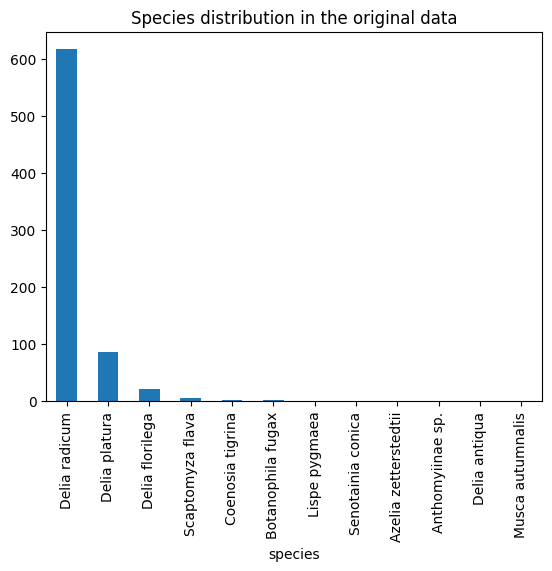

In [8]:
df_og.species.value_counts().plot(kind='bar');
plt.title("Species distribution in the original data");

In [9]:
# In the df_og dataframe, the species should be mapped to the following dict
SPECIES_MAP = {
    'Delia platura': 'v',
    'Delia radicum': 'kv',
    'Delia florilega': 'v',
    'Delia antiqua': 'v',
    'Scaptomyza flava': 'v',
    'Coenosia tigrina': 'v',
    'Botanophila fugax': 'v',
    'Lispe pygmaea': 'v',
    'Senotainia conica': 'v',
    'Azelia zetterstedtii': 'v',
    'Anthomyiinae sp.': 'v',
    'Musca autumnalis': 'v',
}
# All other classes will be labelled as 'other'
df_og['species'] = df_og['species'].map(SPECIES_MAP).fillna('other')

# Let's merge the df_preds with df_og on the Staalcode and the label
df_og['Staalcode'] = df_og['Staalcode'].astype(str)
df_preds['label'] = df_preds['label'].astype(str)

df_merged = df_og.merge(df_preds, left_on='Staalcode', right_on='label', how='left')
df_merged['correct'] = df_merged['species'] == df_merged['pred']
df_merged['correct'] = df_merged['correct'].astype(int)
df_merged

,Jaar,Perceel,Staalnamemoment,Plaatnummer,Vliegnummer,Staalcode,commentaar finaal,species,% Identity in blastn search,pred,label,correct
0,23,A,1,1,308,23A11-308,NaN,v,0.9950,v,23A11-308,1
1,23,A,1,2,23,23A12-23,NaN,kv,0.9734,kv,23A12-23,1
2,23,A,1,2,91,23A12-91,NaN,v,0.9827,kv,23A12-91,0
3,23,A,1,3,134,23A13-134,NaN,v,0.9982,kv,23A13-134,0
4,23,A,1,3,212,23A13-212,NaN,kv,0.9969,kv,23A13-212,1
...,...,...,...,...,...,...,...,...,...,...,...,...
734,23,I,5,2,37,23I52-37,NaN,kv,1.0000,v,23I52-37,0
735,23,I,5,2,42,23I52-42,NaN,kv,0.9950,v,23I52-42,0
736,23,I,5,2,48,23I52-48,NaN,kv,1.0000,v,23I52-48,0
737,23,I,5,2,62,23I52-62,NaN,kv,0.9730,v,23I52-62,0


In [10]:
# Let's drop df_merged rows that don't have a pred
print(f"Shape before dropping rows without a prediction: {df_merged.shape}")
df_merged = df_merged.dropna(subset=['pred'])
print(f"Shape after dropping rows without a prediction: {df_merged.shape}")

Shape before dropping rows without a prediction: (739, 12)
Shape after dropping rows without a prediction: (732, 12)


In [11]:
df_og.species.value_counts(normalize=True)

species
kv    0.834912
v     0.165088
Name: proportion, dtype: float64

In [12]:
df_merged.pred.value_counts(normalize=False)

pred
kv            564
v             163
not_insect      3
wrl             1
m               1
Name: count, dtype: int64

In [13]:
df_merged.correct.value_counts(normalize=True)

correct
1    0.773224
0    0.226776
Name: proportion, dtype: float64

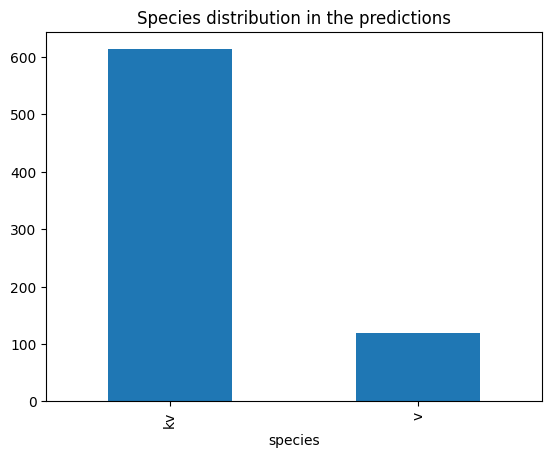

In [14]:
df_merged.species.value_counts().plot(kind='bar');
plt.title("Species distribution in the predictions");

In [15]:
# Let's map the species and the predictions columns to the INSECT_CLASSIFICATION_MAP
df_merged['species'] = df_merged['species'].map(INSECT_CLASSIFICATION_MAP).astype(int)
df_merged['pred'] = df_merged['pred'].map(INSECT_CLASSIFICATION_MAP).astype(int)

/tmp/ipykernel_10291/3886976066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['species'] = df_merged['species'].map(INSECT_CLASSIFICATION_MAP).astype(int)
/tmp/ipykernel_10291/3886976066.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['pred'] = df_merged['pred'].map(INSECT_CLASSIFICATION_MAP).astype(int)


In [16]:
df_merged[df_merged.pred.isna()]

,Jaar,Perceel,Staalnamemoment,Plaatnummer,Vliegnummer,Staalcode,commentaar finaal,species,% Identity in blastn search,pred,label,correct


In [19]:
# Let's calclate the accuracy for each species
species_accuracy = df_merged.groupby('species').correct.mean()
species_accuracy

species
7    0.504202
8    0.825449
Name: correct, dtype: float64

In [20]:
# Let's see the counts of each species that were correctly classified
species_counts = df_merged.groupby('species').correct.value_counts().unstack().fillna(0)
species_counts


correct,0,1
species,,
7,59,60
8,107,506
